<a href="https://colab.research.google.com/github/francescoS01/blob_detection/blob/main/blob_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  **ASSIGNMENT 7: Blob Detector with LoG Filter**
### Francesco Simonetti


In [48]:
!git clone https://github.com/francescoS01/blob_detection.git

fatal: destination path 'blob_detection' already exists and is not an empty directory.


In [49]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage as ndimage
from matplotlib.patches import Circle
import heapq


### **1. Utils**

##### **1.1 blob_detection_plot**:
This function creates a plot of the original image with detected blobs surrounded by circles. It takes an image and a list of detected blob points as input, where each point is represented as a tuple containing the (x, y) coordinates, associated value, and sigma value used for detection. The function plots the image, adds circles around the detected blobs with a radius equal to the sigma value, and displays the resulting plot for visualization and analysis.


In [50]:
def blob_detection_plot(image, points):
    """
    Creates a plot of the original image with detected blobs surrounded by circles.

    ARGS:
    image (ndarray): The image on which blobs were detected.
    points (list): list of points detected during blob detection.
                   each point is represented as a tuple (x, y, value, sigma),where: 
                    - x and y: the coordinates of the point (pixel),
                    - value: associated value (value of pixel) in the coordinate x,y
                    - sigma: is the sigma value used for detection.

    RETURNS:
    None: The image with detected blobs surrounded by circles is displayed.
    """

    image_copiata = np.copy(image)
    fig, ax = plt.subplots()
    ax.imshow(image_copiata, cmap='gray')
    ax.axis('off')

    for point in points:
        x, y, _, sigma = point
        # draw a circle with radius sigma on the original image 
        circle = Circle((y, x), radius=sigma, color='red', fill=False)
        ax.add_patch(circle)
    
    plt.show()
    plt.close()


##### **1.2 find_maxima**: 
This function calculates the maxima (the largest values) of the matrix. It allows the user to specify the maximum number of maxima to find. For each maximum, it creates a quadruple containing the coordinates of the point, its value, and the associated sigma. Finally, it returns all these quadruples within an array.


In [51]:
def find_maxima(matrix, num_max, sigma):
    """
    Finds n maxima in the provided matrix.

    ARGS:
    matrix (numpy.ndarray): The filtered matrix in which to find the maxima.
    num_max (int): The number of maxima to find.
    sigma: The sigma value used to calculate the filtered matrix.

    RETURNS:
    list: A list of tuples containing the maxima, represented as x, y (cooridnate of the point), 
          value (value in the matritrix at point x,y) and sigma.

    """
    
    heap = []

    for x in range(matrix.shape[0]):
        for y in range(matrix.shape[1]):
            valore = matrix[x, y]
            
            if len(heap) < num_max:
                heapq.heappush(heap, (abs(valore), x, y, valore, sigma))
            else:
                heapq.heappushpop(heap, (abs(valore), x, y, valore, sigma))

    punti_massimi = [(x, y, valore, sigma) for (_, x, y, valore, sigma) in heap]

    return punti_massimi

##### **1.3. filter_points**: 
 This function takes a list of points and filters out nearby duplicates. For each point, it checks if there is another point nearby within twice the minimum of their sigma values (which will be the radius of the circle used to locate the identified blob). If such a point is found, it compares their values and keeps the point with the larger value. If no nearby point with a smaller value is found, the current point is added to the filtered list of points.


In [52]:
def filter_points(points):
    """
    Filters the points to remove nearby.

    ARGS:
    points (list): A list of points, where each point is represented as a tuple 
                   containing the coordinates (x, y), value, and associated sigma.

    RETURNS:
    list: A list of filtered maximum points, without nearby duplicates.
    """
    filter_points = []

    for punto in points:
        x1, y1, value1, sigma1 = punto
        trovato = False

        for i, altro_punto in enumerate(filter_points):
            x2, y2, value2, sigma2 = altro_punto
            points_distance = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            min_dist = min(sigma1,sigma2)

            if points_distance < 2*min_dist:
                trovato = True
                # if the current point value is larger, replace the previous point
                if value1 > value2:
                    filter_points[i] = punto
                break

        # if a nearby point with a smaller value was not found, add the current point
        if not trovato:
            filter_points.append(punto)
            

    return filter_points

### **2. Filter and convolution**
##### **2.1 gassian_function**: 
This funciont calcuate the second derivative of the gaussian to each point (x,y) given the sigma value.

##### **2.2 filter_create**: 
This function generates a 2D Gaussian filter for blob detection. It takes a sigma parameter as input, representing the standard deviation of the Gaussian distribution. It calculates the filter size based on sigma, creates a grid of centered coordinates for the filter, computes the Gaussian values for each coordinate using the gaussian_function, and returns the Gaussian filter along with its size.


In [53]:
def gaussian_function(x,y,sigma):
    kernel_value = -1 / (np.pi * sigma ** 2) * (1 - (x ** 2 + y ** 2) / (2 * sigma ** 2)) * np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
    return kernel_value


def filter_create(sigma):
    """
    Creates a 2D Gaussian filter for blob detection.

    ARGS:
    sigma (float): The standard deviation of the Gaussian distribution.

    RETURNS:
    tuple: A tuple containing the Gaussian filter and its size.
    """
    # calculate the size of the filter based on the given sigma value
    x = int(np.ceil(sigma * 6))

    # creation of the centered coordinate grid
    x_values = np.arange(-(x // 2), x // 2 +1)
    y_values = np.arange(-(x // 2), x // 2 +1)
    x, y = np.meshgrid(x_values, y_values)
    filter_size = len(x_values)

    # calculation of pixel values
    filter = gaussian_function(x, y, sigma)

    return filter, filter_size

##### **2.3 filter_convolution**:
This function performs convolution between an input image and a given filter. It iterates over the image, calculating the element-wise product between the filter and the corresponding portion of the image at each position. The result of the convolution is stored in a resulting matrix, which is then returned as the output of the function. In summary, the function applies the filter on the image using convolution and returns the convolved result.ihgqhewr

In [54]:
def filter_convolution(image, filter, filter_size):
    """
    Performs convolution between an image and a filter.

    ARGS:
    image (numpy.ndarray): The input image.
    filter (numpy.ndarray): The filter matrix.
    filter_size (int): The size of the filter.
    
    RETURNS:
    numpy.ndarray: The result of the convolution operation.
    """

    # image dim
    image_row, image_col = image.shape[:2]

    # filter dim
    filter_col = filter_size
    filter_row = filter_size

    # filter_matrix (inizalize to 0)
    filter_matrix_row = (image_row - filter_row) +1
    filter_matrix_col = (image_col - filter_col) +1
    filter_matrix = np.zeros((filter_matrix_row, filter_matrix_col))

    for x in range(filter_matrix_row):
        for y in range(filter_matrix_col):
            filter_matrix[x, y] = np.sum(image[x:x + filter_size, y:y + filter_size] * filter)

    return filter_matrix

### **3. Complete Program Execution**

##### **3.1 blob_detection:**
This function executes blob detection on an image using the Laplacian of Gaussian (LoG) method. It takes a list of sigma values, an image path, and the maximum number of points of interest to be detected for each sigma scale as input. The function loads the image, converts it to grayscale, and initializes an array to store the points of interest. 

For each sigma value in the provided list, the function creates a LoG filter (`filter_create`), convolves it with the image (`filter_convolution`), and identifies the maximum points of interest using the `find_maxima` function. 

After detecting the maximum points for all sigma scales, the function filters out points that are very close to each other with respect to sigma (`filter_points`). Finally, it plots the input image with detected blobs surrounded by circles using the `blob_detection_plot` function.



In [55]:
def blob_detection(sigmas, image_path, num_max):
    """
    executes blob detection on an image using the Laplacian of Gaussian (LoG) method.

    ARGS:
    sigmas (list): List of sigma values to use for creating LoG filters.
    image_path (str): Path of the image on which to perform blob detection.
    num_max (int): Maximum number of points of interest to be detected for each sigma scale.

    RETURNS:
    No directly returned value. The function creates a plot of the input image with detected blobs surrounded by circles.
    """

    # image
    im = Image.open(image_path) 
    image = np.array(im)
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # array taht contain the points of interest
    max_points = []

    for sigma in sigmas:

        # create the filter and take its dimention
        filter, filter_size = filter_create(sigma)

        # do the padding to maintain the coordinates
        image_padding = np.pad(gray_image, int((filter_size-1)/2), mode='edge')

        # convolution of filter on the image
        filter_image = filter_convolution(image_padding, filter, filter_size)

        # take num_max max of the filter image with fixed sigma
        max_points += find_maxima(filter_image, num_max, sigma)


    # points that are very close to each other with respect to sigma are eliminated
    max_points = filter_points(max_points.copy())

    # the points of interest are circled and the plot is made
    blob_detection_plot(gray_image, max_points)


### **4. Results**

In [56]:
# both fixed for all results
sigmas = [2, 4, 8, 16, 32]
num_max = 400

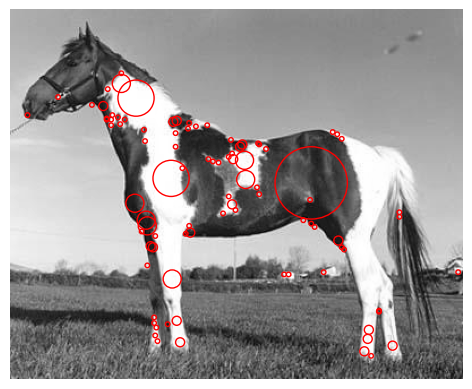

In [57]:
# image 1
image_path = "blob_detection/image/horse069.png"
blob_detection(sigmas, image_path, num_max)

##### **First image result:** 
It can be observed that the blobs are mainly distributed over the horse's body. No points of interest were noticed in the background; only four blobs with very small sigma values were detected. Near the hind thigh, a large-sized blob is noticeable, indicating that the detection responds with high values using a high sigma value at that point. In other parts of the body, however, the detector tends to obtain higher values for small sigma values. Indeed, many circles of small radii can be noticed.

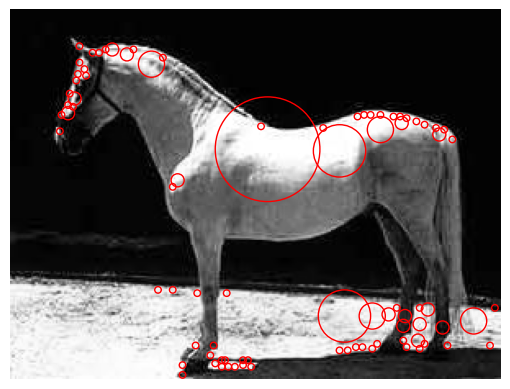

In [58]:
# image 2
image_path = "blob_detection/image/horse024.png"
blob_detection(sigmas, image_path, num_max)

##### **Second image result:** 
In this case as well, blobs tend to respond with high values when using small sigma values. A significant area of interest can be observed along the horse's muzzle and in the upper back part. In these areas, blobs appear to distribute themselves following the contour of the horse's body. A large sigma blob is detected in the center of the horse's body. Conversely, no points of interest are found in the upper part of the background, likely due to a large area of uniform values. However, several blobs have been identified in the lower part of the background.

In [59]:
# image 3
image_path = "blob_detection/image/horse094.png"
blob_detection(sigmas, image_path, num_max)

##### **Third image result:** 
In this case, we can observe that not even a single blob has been detected in the background. Intuitively, this follows the same reasoning as in the previous image. Among the major areas of interest, we have the muzzle and the legs, where, as in the previous image, the blobs seem to align along the contours of the horse. Two large blobs are identified beneath the horse's neck, in a very bright and homogeneous area.

### **5. Consideration** 
The implementation of the blob detector has greatly clarified the theoretical concepts studied. During the implementation, it was possible to observe how small variations in a parameter (e.g., filter size or the sigma values used) can significantly influence the final result.

In my implementation, for simplicity, I decided to take a certain number of maxima for each sigma and then subsequently clean up by removing blobs that are too close to each other, keeping only those with higher values. However, this approach could be improved, as in the unfortunate case where, for a certain sigma, all the highest values are clustered in the same area. In this scenario, we might end up selecting only those blobs and then removing them subsequently during the cleaning phase (as they are all very close together), thereby neglecting other potential areas of interest. One possible solution to address this issue could be to select the maximum values above a certain threshold, with further exploration needed to determine an appropriate threshold value.

As a final observation, after many examples, I noticed that the detector tends to respond with generally higher values when using a smaller sigma.